In [ ]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import numpy as np
import gzip
import shutil
import os
from shapely.geometry import Point
from shapely.geometry import Polygon
import time
import logging
from datetime import datetime
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('font', family='DejaVu Sans')
from functools import reduce
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_squared_error
import shap
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import  KFold
import optuna

import warnings
warnings.filterwarnings("ignore")

In [410]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

start_time = time.time()
logging.info("Starting pipeline...")

2025-07-07 08:14:45,817 - Starting pipeline...


In [411]:
H3_RESOLUTION = 8
TARGET_TYPE = 'Sewer: Blocked/Overflow'

In [412]:
#load the data

t0 = time.time()

file_name = "sr_hex.csv.gz"
var_name = "df_sr_hex"
base_url = "https://cct-ds-code-challenge-input-data.s3.af-south-1.amazonaws.com/"
url = base_url + file_name

print(f"Processing {file_name}...")
!wget -q {url}

# Unzip and load
csv_name = file_name[:-3]  
with gzip.open(file_name, 'rb') as f_in:
    with open(csv_name, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

df = pd.read_csv(csv_name)
os.remove(csv_name)
os.remove(file_name)  

# --- Download geojson hex polygons ---
geojson_file = "city-hex-polygons-8.geojson"
geojson_url = base_url + geojson_file

print(f"Downloading {geojson_file}...")
!wget -q {geojson_url}

# Load hex polygons
gdf_hex = gpd.read_file(geojson_file)


logging.info(f"Loaded data in {time.time() - t0:.2f} seconds")

Processing sr_hex.csv.gz...


2025-07-07 08:14:58,140 - Loaded data in 12.24 seconds


In [413]:

# Drop Records where h3_level8_index = '0' / is missing
print(df.shape)
df = df.loc[df.h3_level8_index != '0']
print(df.shape)

(941634, 16)


(729270, 16)


In [414]:
#Filter out records for TARGET_TYPE
df_type = df[df['code'] == TARGET_TYPE].groupby(['h3_level8_index'])['notification_number'].count().reset_index(name='num_requests')

In [415]:
print(gdf_hex.columns)

Index(['index', 'centroid_lat', 'centroid_lon', 'geometry'], dtype='object')


In [416]:
# #Helper function
# def h3_to_point(h3, resolution=8):
#     return h3_to_geo(h3)

# # Convert each h3_index to lat/lon
# df_type[['latitude', 'longitude']] = df_type['h3_level8_index'].apply(lambda h: pd.Series(h3_to_point(h)))

# Rename hex index column to match df_type
gdf_hex = gdf_hex.rename(columns={"index": "h3_level8_index"})

# Add centroid lat/lon
gdf_hex["centroid"] = gdf_hex.geometry.centroid
gdf_hex["latitude"] = gdf_hex.centroid.y
gdf_hex["longitude"] = gdf_hex.centroid.x

# Merge lat/lon into df_type
df_type = df_type.merge(
    gdf_hex[["h3_level8_index", "latitude", "longitude"]],
    on="h3_level8_index",
    how="left"
)


## Initial Solution - Baseline Model

In [417]:
t0 = time.time()
X = df_type.drop(['num_requests'], axis=1)
X = X.set_index('h3_level8_index')
y = df_type['num_requests']

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)

#_train = np.log1p(y_train)
regressor = RandomForestRegressor(n_estimators = 50,oob_score = True, random_state=42)
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
#y_pred = np.expm1(y_log_pred)

oob_score = regressor.oob_score_
print(f'Out-of-Bag Score: {oob_score}')

print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R2:", r2_score(y_test, y_pred))

logging.info(f"Baseline / Initial model trained in {time.time() - t0:.2f} seconds")

2025-07-07 08:14:58,838 - Baseline / Initial model trained in 0.15 seconds


Out-of-Bag Score: 0.26485835669755387
RMSE: 114.7303309986676
R2: 0.3054825288781825


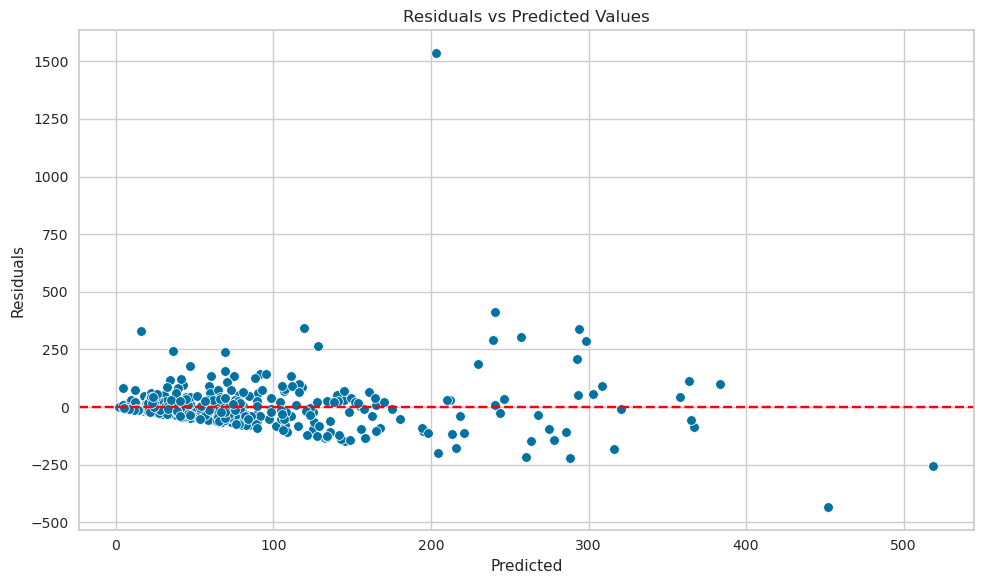

In [418]:
#Residual plot
y_pred = regressor.predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.tight_layout()
plt.grid(True)
plt.savefig("../outputs/baseline_residuals.png") 
plt.show()


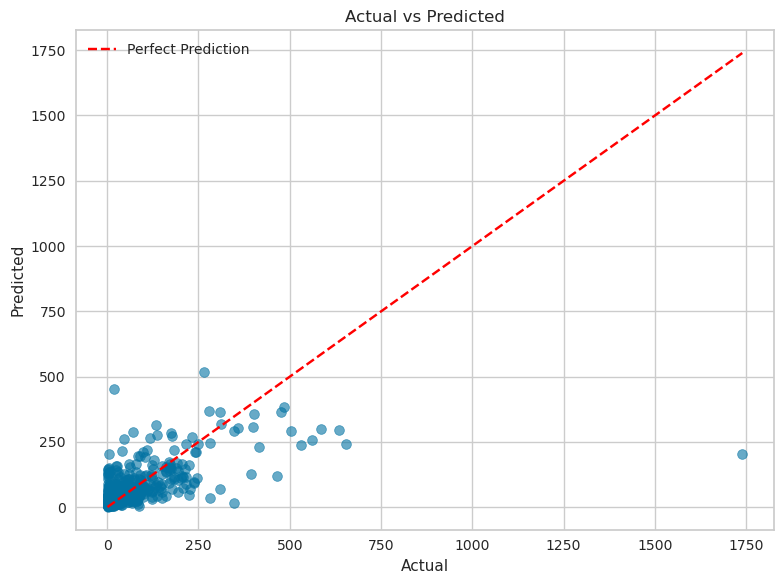

In [419]:
#Actual vs Predicted Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, edgecolor=None)

# 45-degree reference line
max_val = max(max(y), max(y_pred))
min_val = min(min(y), min(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], '--', color='red', label='Perfect Prediction')

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.legend()
plt.grid(True)
plt.tight_layout()


plt.savefig("../outputs/baseline_pred_vs_actual.png")
plt.show()

## Improved Solution
### Feature Engineering - Add External Data

In [420]:
t0 = time.time()

# -------------------------------
# Settings
# -------------------------------
place_name = "City of Cape Town, Western Cape, South Africa"

feature_tags = {
    "num_schools": {"amenity": "school"},
    "num_shops": {"shop": True},
    "num_bus_stops": {"highway": "bus_stop"},
    "num_clinics": {"amenity": "clinic"},
    "num_hospitals": {"amenity": "hospital"},
    "num_post_offices": {"amenity": "post_office"},
    "num_pharmacies": {"amenity": "pharmacy"},
    "num_banks": {"amenity": "bank"},
    "num_traffic_signals": {"highway": "traffic_signals"},
    "num_religious_sites": {"amenity": ["place_of_worship", "church", "mosque", "synagogue", "temple"]},
}

# -------------------------------
# Load boundary and hex grid
# -------------------------------
print("Fetching Cape Town boundary...")
gdf_boundary = ox.geocode_to_gdf(place_name)
polygon = gdf_boundary.geometry.unary_union

print("Loading city hex grid...")
gdf_hex = gpd.read_file("city-hex-polygons-8.geojson")
gdf_hex = gdf_hex.rename(columns={"index": "h3_level8_index"})

# -------------------------------
# Updated aggregation function (no H3)
# -------------------------------
def extract_and_aggregate_spatial(tag_label, tag_filter):
    print(f"Fetching {tag_label}...")
    try:
        time.sleep(2)
        gdf = ox.features_from_polygon(polygon, tags=tag_filter)
    except Exception as e:
        print(f"Failed to fetch {tag_label}: {e}")
        return pd.DataFrame(columns=["h3_level8_index", tag_label])

    gdf = gdf[gdf.geometry.notna()].copy()

    # Convert polygons to centroids
    if gdf.geom_type.isin(['Polygon', 'MultiPolygon']).any():
        gdf['geometry'] = gdf['geometry'].centroid

    # Keep only point geometry
    gdf = gdf[gdf.geometry.type == 'Point']

    # Spatial join with hex grid
    gdf_joined = gpd.sjoin(gdf, gdf_hex, how="inner", predicate="within")

    # Count features per hex
    agg = gdf_joined.groupby("h3_level8_index").size().reset_index(name=tag_label)
    return agg

# -------------------------------
# Loop and Merge All Features
# -------------------------------
h3_feature_dfs = []

for label, tag in feature_tags.items():
    h3_df = extract_and_aggregate_spatial(label, tag)
    h3_feature_dfs.append(h3_df)

print("Merging all feature tables...")
df_h3_features = reduce(
    lambda left, right: pd.merge(left, right, on='h3_level8_index', how='outer'),
    h3_feature_dfs
)

df_h3_features.fillna(0, inplace=True)

# -------------------------------
# Final Output
# -------------------------------
print("Final H3 feature summary:")
display(df_h3_features.head())

Fetching Cape Town boundary...
Loading city hex grid...
Fetching num_schools...


Fetching num_shops...
Fetching num_bus_stops...
Fetching num_clinics...
Fetching num_hospitals...
Fetching num_post_offices...
Fetching num_pharmacies...
Fetching num_banks...
Fetching num_traffic_signals...
Fetching num_religious_sites...
Merging all feature tables...
Final H3 feature summary:


,h3_level8_index,num_schools,num_shops,num_bus_stops,num_clinics,num_hospitals,num_post_offices,num_pharmacies,num_banks,num_traffic_signals,num_religious_sites
0,88ad360003fffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
1,88ad360005fffff,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0
2,88ad360007fffff,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,11.0,0.0
3,88ad360021fffff,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,88ad360023fffff,1.0,2.0,5.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0


In [421]:
#merge df_h3_features with df_type
print(df_type.shape)
df_type = pd.merge(df_type, df_h3_features, on='h3_level8_index', how='left')
df_type.fillna(0,inplace=True)
print(df_type.shape)
df_type.head()

(1501, 4)
(1501, 14)


,h3_level8_index,num_requests,latitude,longitude,num_schools,num_shops,num_bus_stops,num_clinics,num_hospitals,num_post_offices,num_pharmacies,num_banks,num_traffic_signals,num_religious_sites
0,88ad360001fffff,21,-33.836215,18.494066,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,88ad360003fffff,12,-33.832471,18.485002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
2,88ad360005fffff,54,-33.832062,18.502176,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0
3,88ad360007fffff,41,-33.828319,18.493112,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,11.0,0.0
4,88ad36000dfffff,15,-33.839958,18.503130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [422]:
#Number of request types (excluding TARGET_TYPE)  per h3_level8_index

unique_types_per_hex = df[df.code != TARGET_TYPE].groupby('h3_level8_index')['code'].nunique().reset_index()
unique_types_per_hex.columns = ['h3_level8_index', 'num_unique_request_types']

# Preview result
unique_types_per_hex.sort_values('num_unique_request_types', ascending=False).head()

,h3_level8_index,num_unique_request_types
685,88ad361519fffff,185
716,88ad3615c1fffff,164
698,88ad361547fffff,164
697,88ad361545fffff,161
123,88ad36024bfffff,155


In [423]:
#merge unique_types_per_hex with df_type
print(df_type.shape)
df_type = pd.merge(df_type, unique_types_per_hex, on='h3_level8_index', how='left')
df_type.fillna(0,inplace=True)
print(df_type.shape)

(1501, 14)
(1501, 15)


In [424]:
#dominant request type per h3_level8_index excluding TARGET_TYPE

dominant_counts = (
    df[df.code != TARGET_TYPE].groupby(['h3_level8_index', 'code']).size()
    .reset_index(name='count')
    .sort_values(['h3_level8_index', 'count'], ascending=[True, False])
    .drop_duplicates('h3_level8_index')
    .rename(columns={'code': 'dominant_request_type', 'count': 'dominant_type_count'})
)

#merge dominant_counts with df_type
print(df_type.shape)
df_type = pd.merge(df_type, dominant_counts, on='h3_level8_index', how='left')
df_type['dominant_request_type'] = df_type['dominant_request_type'].fillna('Unknown')
df_type['dominant_type_count'] = df_type['dominant_type_count'].fillna(0).astype(int)
print(df_type.shape)


logging.info(f"Feature engineering completed in {time.time() - t0:.2f} seconds")

2025-07-07 08:15:23,823 - Feature engineering completed in 24.24 seconds


(1501, 15)
(1501, 17)


In [425]:
# Train the model
t0 = time.time()

X = df_type.drop(columns = ["num_requests"], axis = 1)
X = X.set_index("h3_level8_index")
y = df_type["num_requests"]

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)

numeric_features = selector(dtype_include='number')(X_train)
categorical_features = selector(dtype_include='object')(X_train)

#Ensure categorical columns are all string type
X_train[categorical_features] = X_train[categorical_features].astype(str)
X_test[categorical_features] = X_test[categorical_features].astype(str)

# Pipelines
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
('regressor', LGBMRegressor(random_state=42))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R2:", r2_score(y_test, y_pred))

logging.info(f"Improved model trained in {time.time() - t0:.2f} seconds")

2025-07-07 08:15:23,948 - Improved model trained in 0.12 seconds


RMSE: 105.959589492705
R2: 0.4076106852143727


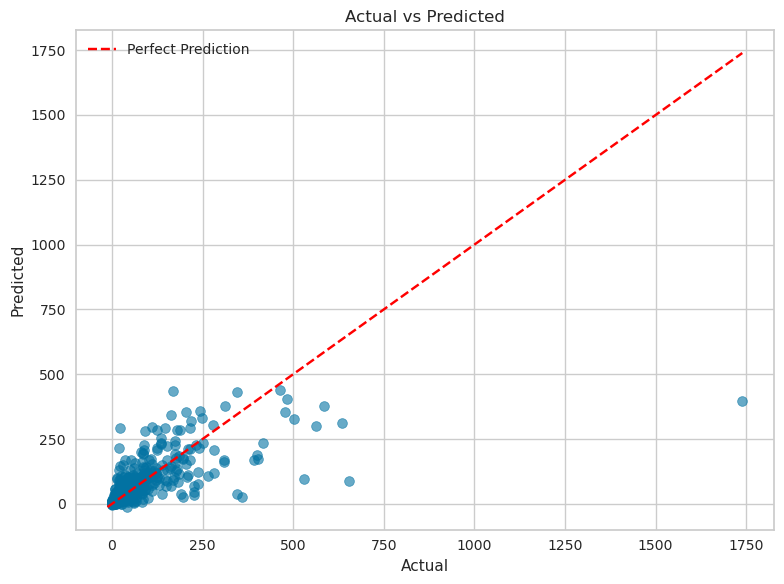

In [426]:
#Actual vs Predicted Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, edgecolor=None)

# 45-degree reference line
max_val = max(max(y), max(y_pred))
min_val = min(min(y), min(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], '--', color='red', label='Perfect Prediction')

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.legend()
plt.grid(True)
plt.tight_layout()


plt.savefig("../outputs/improved_pred_vs_actual.png")
plt.show()              

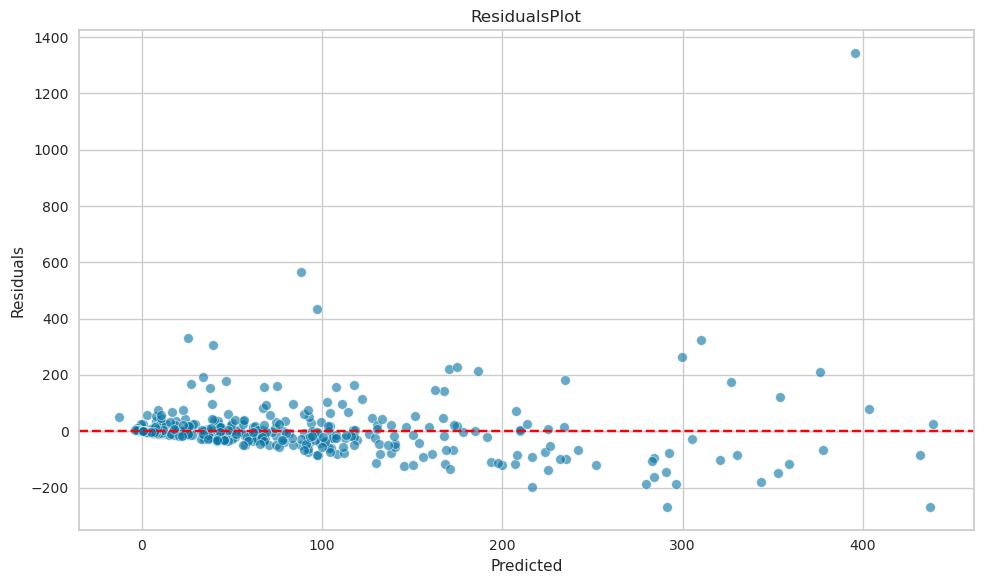

In [427]:
#Residual plot
y_pred = pipeline.predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("ResidualsPlot")
plt.grid(True)
plt.tight_layout()


plt.savefig("../outputs/improved_residuals.png") 
plt.show()


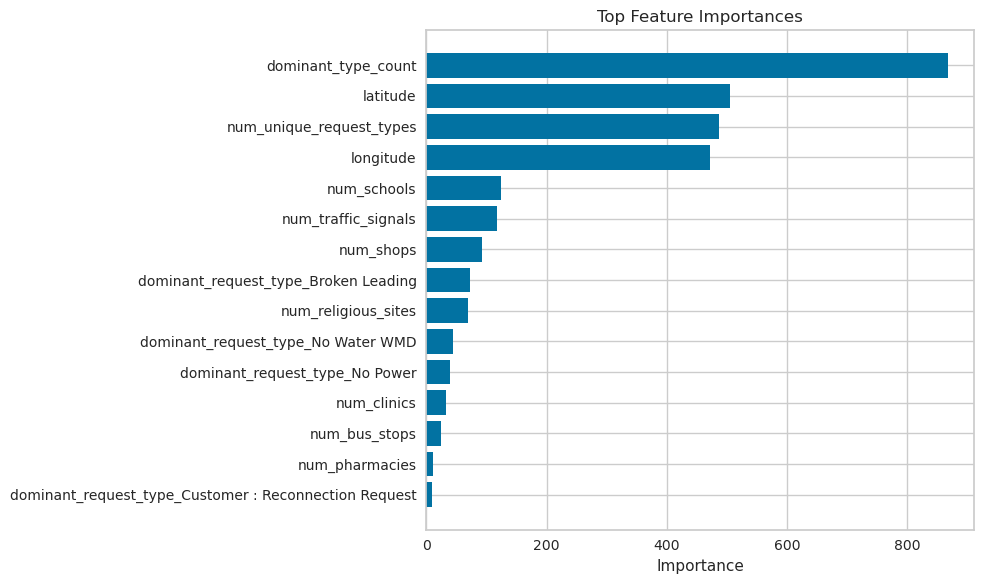

In [428]:
#Feature Importance

model = pipeline.named_steps['regressor']

# Feature Names
num_features = numeric_features
cat_encoder = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)
feature_names = np.concatenate([num_features, cat_feature_names])

# Imporances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot top N
N = 15
plt.figure(figsize=(10, 6))
plt.title("Top Feature Importances")
plt.barh(range(N), importances[indices[:N]][::-1])
plt.yticks(range(N), feature_names[indices[:N]][::-1])
plt.xlabel("Importance")
plt.tight_layout()
plt.savefig("../outputs/improved_feature_importance.png") 
plt.show()

### Hyperparameter Tuning

In [429]:
t0 = time.time()

def objective(trial):
    # LightGBM hyperparameters
    params = {
        "objective": "regression",
        "metric": "rmse",
        "boosting_type": "gbdt",
        "n_estimators": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 16, 256),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 100),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-4, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-4, 10.0, log=True),
        "verbosity": -1,
    }

    # Split numeric and categorical features
    num_cols = X.select_dtypes(include="number").columns.tolist()
    cat_cols = X.select_dtypes(include="object").columns.tolist()

    # Preprocessing pipeline
    numeric_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ])

    categorical_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse=False))
    ])

    preprocessor = ColumnTransformer([
        ("num", numeric_pipeline, num_cols),
        ("cat", categorical_pipeline, cat_cols)
    ])

    # Final model pipeline
    model = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", LGBMRegressor(**params, random_state=42))
    ])

    # 5-fold CV with RMSE scoring
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=cv, scoring="neg_root_mean_squared_error")

    return -np.mean(scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2025-07-07 08:15:25,026] A new study created in memory with name: no-name-bc3e098b-cb92-4c02-adad-239814e8ae79
[I 2025-07-07 08:15:26,416] Trial 0 finished with value: 95.67867637157755 and parameters: {'learning_rate': 0.0012992811990394247, 'num_leaves': 204, 'max_depth': 4, 'min_child_samples': 78, 'min_data_in_leaf': 57, 'subsample': 0.506497805165123, 'colsample_bytree': 0.6422835476248392, 'reg_alpha': 1.1155065076978175, 'reg_lambda': 0.052604926282000156}. Best is trial 0 with value: 95.67867637157755.
[I 2025-07-07 08:15:27,681] Trial 1 finished with value: 87.73409040699592 and parameters: {'learning_rate': 0.025624422194858623, 'num_leaves': 202, 'max_depth': 14, 'min_child_samples': 50, 'min_data_in_leaf': 99, 'subsample': 0.9670403713170276, 'colsample_bytree': 0.6357676676352929, 'reg_alpha': 0.2933717863194736, 'reg_lambda': 0.09633771373561548}. Best is trial 1 with value: 87.73409040699592.
[I 2025-07-07 08:15:29,181] Trial 2 finished with value: 85.74510221399446 a

Best hyperparameters: {'learning_rate': 0.010840286396818125, 'num_leaves': 51, 'max_depth': 6, 'min_child_samples': 99, 'min_data_in_leaf': 37, 'subsample': 0.6581982021935513, 'colsample_bytree': 0.5157903621542312, 'reg_alpha': 0.00014311733933200873, 'reg_lambda': 0.7630531440623363}
Best RMSE: 84.6055106993699


In [430]:
params = study.best_params

numeric_features = selector(dtype_include='number')(X_train)
categorical_features = selector(dtype_include='object')(X_train)

# Pipelines
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LGBMRegressor(**params,
                                objective= "regression",
                                metric="rmse",
                                n_estimators=1000,
                                verbosity= -1,
                                bagging_freq= 1,
                                random_state=42))
])  

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R2:", r2_score(y_test, y_pred))

logging.info(f"Optimized model trained in {time.time() - t0:.2f} seconds")


2025-07-07 08:16:54,068 - Optimized model trained in 89.04 seconds


RMSE: 101.74632784946948
R2: 0.4537843112383543


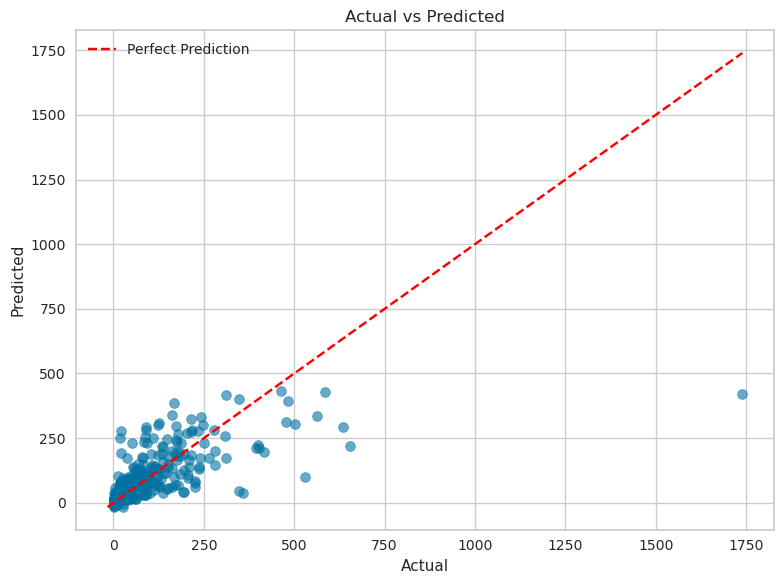

In [431]:

#Actual vs Predicted Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, edgecolor=None)

# 45-degree reference line
max_val = max(max(y), max(y_pred))
min_val = min(min(y), min(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], '--', color='red', label='Perfect Prediction')

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.legend()
plt.grid(True)
plt.tight_layout()


plt.savefig("../outputs/optimized_pred_vs_actual.png")
plt.show()

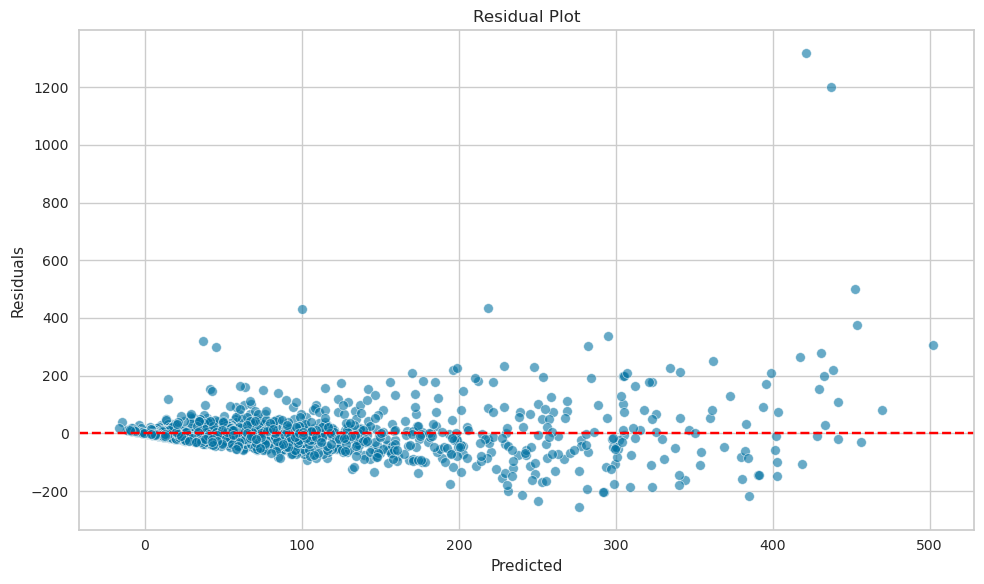

In [432]:
#Residual plot
y_pred = pipeline.predict(X)
residuals = y - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.grid(True)
plt.tight_layout()

plt.savefig("../outputs/optimized_residuals.png") 
plt.show()


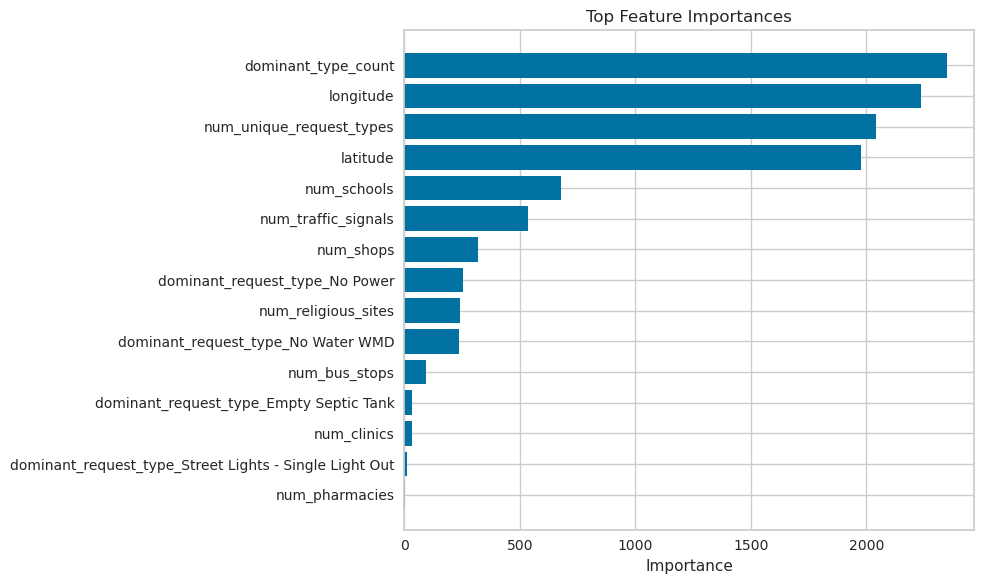

In [433]:
#Feature Importance

model = pipeline.named_steps['regressor']

# Feature Names
num_features = numeric_features
cat_encoder = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)
feature_names = np.concatenate([num_features, cat_feature_names])

# Imporances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot top N
N = 15
plt.figure(figsize=(10, 6))
plt.title("Top Feature Importances")
plt.barh(range(N), importances[indices[:N]][::-1])
plt.yticks(range(N), feature_names[indices[:N]][::-1])
plt.xlabel("Importance")
plt.tight_layout()
plt.savefig("../outputs/optimized_feature_importance.png") 
plt.show()

### Use the final model to predict the full dataset

In [434]:
params = study.best_params

numeric_features = selector(dtype_include='number')(X)
categorical_features = selector(dtype_include='object')(X)

# Pipelines
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LGBMRegressor(**params,
                                objective= "regression",
                                metric="rmse",
                                n_estimators=1000,
                                verbosity= -1,
                                bagging_freq= 1,))
                            ])  

pipeline.fit(X, y)
y_pred = pipeline.predict(X)

print("RMSE:", mean_squared_error(y, y_pred, squared=False))
print("R2:", r2_score(y, y_pred))

RMSE: 70.5558564278471
R2: 0.6997024530687493


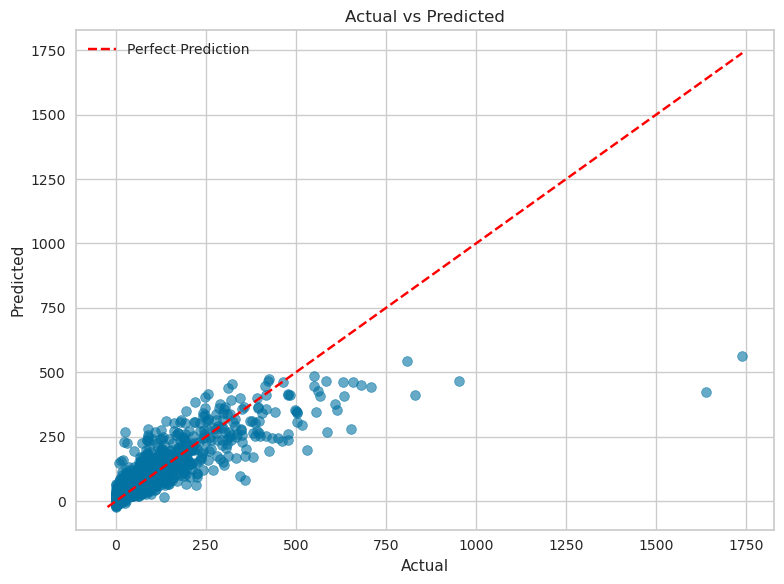

In [435]:
#Actual vs Predicted Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y, y=y_pred, alpha=0.6, edgecolor=None)

# 45-degree reference line
max_val = max(max(y), max(y_pred))
min_val = min(min(y), min(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], '--', color='red', label='Perfect Prediction')

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.legend()
plt.grid(True)
plt.tight_layout()


plt.savefig("../outputs/final_pred_vs_actual.png")
plt.show()

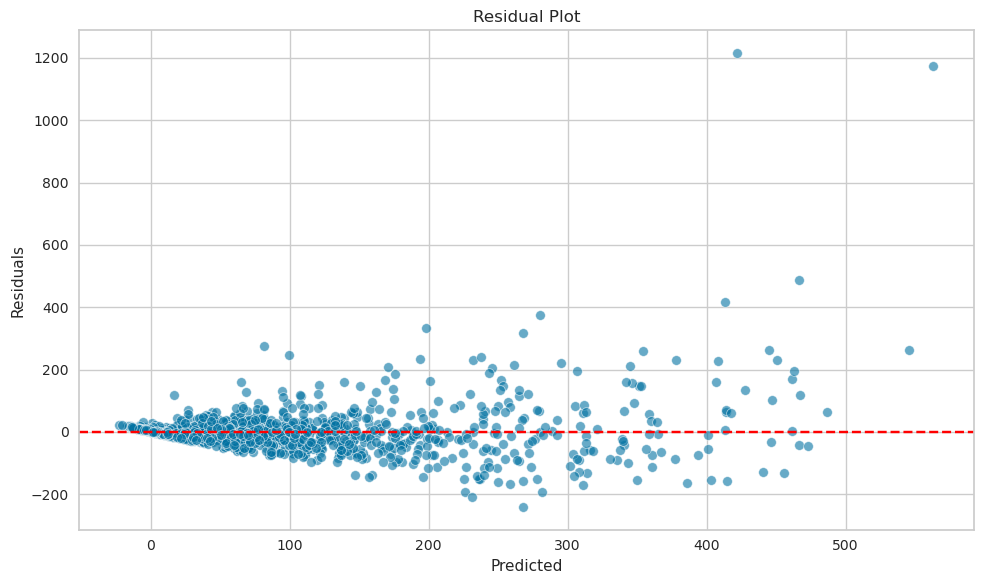

In [436]:
#Residual plot
y_pred = pipeline.predict(X)
residuals = y - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.grid(True)
plt.tight_layout()

plt.savefig("../outputs/final_residuals.png") 
plt.show()


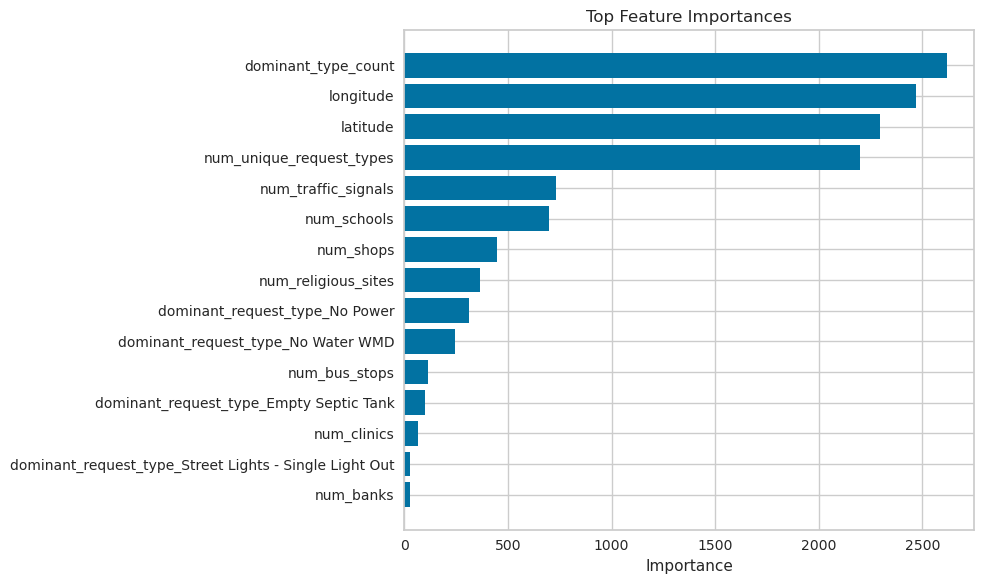

In [437]:
#Feature Importance

model = pipeline.named_steps['regressor']

# Feature Names
num_features = numeric_features
cat_encoder = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)
feature_names = np.concatenate([num_features, cat_feature_names])

# Imporances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot top N
N = 15
plt.figure(figsize=(10, 6))
plt.title("Top Feature Importances")
plt.barh(range(N), importances[indices[:N]][::-1])
plt.yticks(range(N), feature_names[indices[:N]][::-1])
plt.xlabel("Importance")
plt.tight_layout()
plt.savefig("../outputs/final_feature_importance.png") 
plt.show()

## Spatial Prediction Comparison

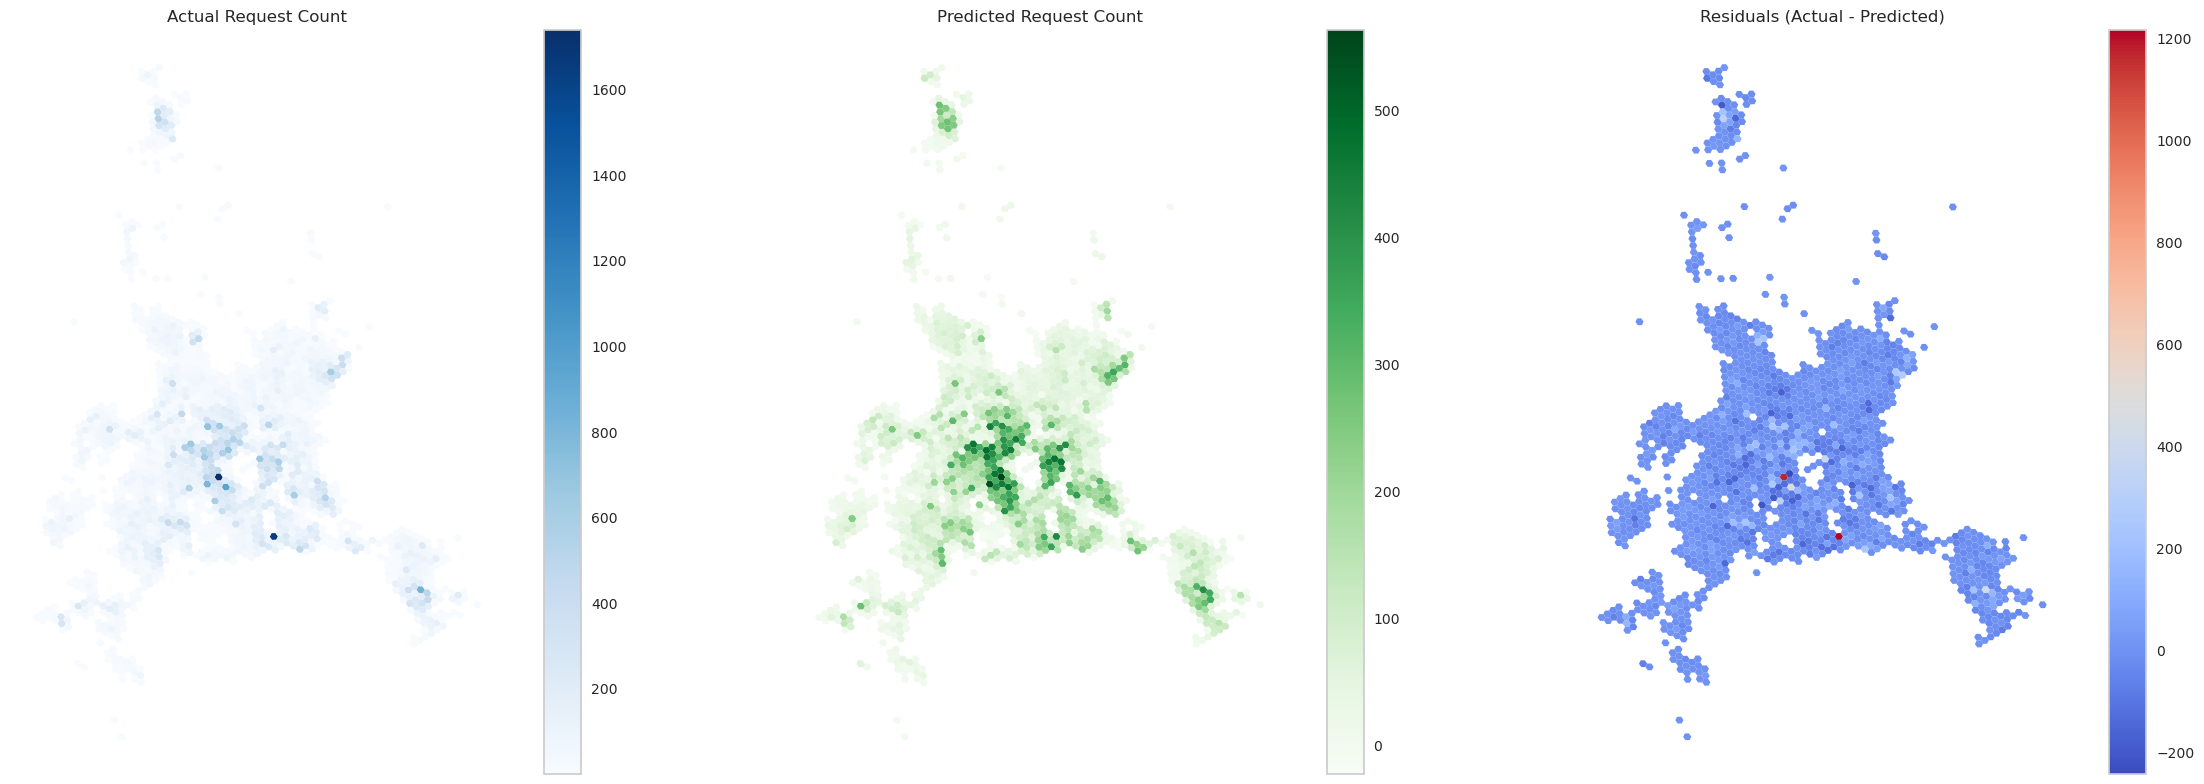

In [438]:
results_df = X.copy()
results_df = results_df.reset_index()
results_df['actual'] = y
results_df['predicted'] = y_pred
results_df['residual'] = results_df['actual'] - results_df['predicted']
results_df['h3_index'] = results_df['h3_level8_index']

# 3. Convert h3 index to polygon
def h3_to_geo_boundary(h):
    boundary = h3.h3_to_geo_boundary(h, geo_json=True)
    return Polygon(boundary)

results_df = results_df[results_df['h3_index'].notna()].copy()
results_df['geometry'] = results_df['h3_index'].apply(h3_to_geo_boundary)
gdf = gpd.GeoDataFrame(results_df, geometry='geometry', crs='EPSG:4326')

# 4. Plot actual vs predicted vs residuals
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Actual
gdf.plot(column='actual', cmap='Blues', legend=True, ax=axes[0])
axes[0].set_title("Actual Request Count")

# Predicted
gdf.plot(column='predicted', cmap='Greens', legend=True, ax=axes[1])
axes[1].set_title("Predicted Request Count")

# Residuals
gdf.plot(column='residual', cmap='coolwarm', legend=True, ax=axes[2])
axes[2].set_title("Residuals (Actual - Predicted)")

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.savefig("../outputs/spatial_prediction_comparison.png") 

plt.show()

In [439]:
# Total time
logging.info(f"Total runtime: {time.time() - start_time:.2f} seconds")

2025-07-07 08:16:58,892 - Total runtime: 133.07 seconds
